In [6]:
from pyproj import datadir
datadir.set_data_dir("/home/jupyter-daniela/.conda/envs/peru_environment/share/proj")

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import json 


In [7]:
class CalasDataset:
    def __init__(self, ruta_base):
        self.ruta_base = Path(ruta_base)
        self.df = None

    def cargar_datos(self, anio):
        """Carga todos los archivos de calas del año especificado ya sea de primera o segunda temporada."""
        carpeta = self.ruta_base / "ihma_data" / str(anio)
        archivos = list(carpeta.glob("*.csv"))
        archivos_filtrados = [
            a for a in archivos
            if re.search(r'Calas', a.name, re.IGNORECASE)
            and (re.search(r'Primera temporada', a.name, re.IGNORECASE) or re.search(r'Segunda temporada', a.name, re.IGNORECASE))
            and re.search(r'anchoveta', a.name, re.IGNORECASE)
        ]

        if not archivos_filtrados:
            raise FileNotFoundError(f"No se encontró archivo con 'Calas' y 'Primera o Segunda temporada' en {carpeta}")

        dfs = [pd.read_csv(a, low_memory=False) for a in archivos_filtrados]
        self.df = pd.concat(dfs, ignore_index=True)

        self.df['fecha_cala'] = pd.to_datetime(self.df['fecha_cala'], format='%d/%m/%Y')
        self.df['declarado_tm'] = pd.to_numeric(self.df['declarado_tm'], errors='coerce')
        self.df['porcentaje_juvenil '] = pd.to_numeric(self.df['porcentaje_juvenil '], errors='coerce')
        self.df['semana'] = self.df['fecha_cala'].dt.isocalendar().week
        return self.df

    def estadisticas_datos(self):
        if self.df is None:
            raise ValueError("Primero debes cargar los datos con cargar_datos()")
        df = self.df

        filas = []
        for temporada, df_temp in df.groupby("temporada"):
            if df_temp.empty:
                continue
            duracion = (df_temp['fecha_cala'].max() - df_temp['fecha_cala'].min()).days
            total_pescado = df_temp['declarado_tm'].sum()

            start_date = df_temp['fecha_cala'].min()
            end_date = df_temp['fecha_cala'].max()

            empresas = (
                df_temp.groupby("empresa")['declarado_tm']
                .sum()
                .reset_index()
                .rename(columns={'declarado_tm': 'volumen_tm'})
            )
            for _, row in empresas.iterrows():
                filas.append({
                    "temporada": temporada,
                    "fecha_inicio": start_date,
                    "fecha_fin": end_date,
                    "duracion_dias": duracion,
                    "total_pescado_tm": total_pescado,
                    "empresa": row['empresa'],
                    "volumen_empresa_tm": row['volumen_tm']
                })
        return pd.DataFrame(filas)



    def grillado_semanal(self, lat_bins, lon_bins):
        """
        Realiza un grillado semanal de la data de calas: suma de lo pescado por celda y semana.
        Devuelve un DataFrame con columnas: ['semana', 'lat_bin', 'lon_bin', 'suma_pescado', 'temporada']
        """

        if self.df is None:
            raise ValueError("Primero debes cargar los datos con cargar_datos()")
        df = self.df.copy()

        df['lat_bin'] = pd.cut(df['latitud '], bins=lat_bins, labels=lat_bins[:-1], include_lowest=True)
        df['lon_bin'] = pd.cut(df['longitud'], bins=lon_bins, labels=lon_bins[:-1], include_lowest=True)

        resultados = []

        for temporada in df['temporada'].dropna().unique():
            df_temporada = df[df['temporada'] == temporada]

            resultado = (
                df_temporada.groupby(['semana', 'lat_bin', 'lon_bin'], dropna=False)['declarado_tm']
                .sum()
                .reset_index()
                .rename(columns={'declarado_tm': 'suma_pescado'})
            )

            resultado['temporada'] = temporada
            resultados.append(resultado)

        grilla = pd.concat(resultados, ignore_index=True)

        return grilla


class CalasManager:
    def __init__(self, base_path, years):
        self.base_path = Path(base_path)
        self.datasets = {}
        self.years = years

    def load_all_years(self):
        for anio in self.years:
            ds = CalasDataset(self.base_path)
            try:
                ds.cargar_datos(anio)
                self.datasets[anio] = ds
            except FileNotFoundError:
                continue

    def concatenate_datasets(self):
        dfs = [ds.df for ds in self.datasets.values() if ds.df is not None]
        if not dfs:
            raise ValueError("No se encontraron datos en los años especificados")
        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    def grilla_multianual(self, lat_bins, lon_bins):
        """
        Genera una grilla semanal concatenada para los años y variable especificados.
        """
        df_todos = self.concatenate_datasets()
        if df_todos.empty:
            raise ValueError("No hay datos para concatenar")
        ds = CalasDataset(self.base_path)
        ds.df = df_todos
        grilla = ds.grillado_semanal(lat_bins, lon_bins)
        return df_todos, grilla

class CalasVisualizer:
    def __init__(self, boundary_path):
        self.boundary = gpd.read_file(boundary_path)

    def visualizar_datos(self, anio):
        """Visualiza los datos de calas sobre el mapa base de países, una figura por temporada."""
        if not hasattr(self, "df"):
            raise ValueError("Primero debes cargar los datos con cargar_datos()")
        df = self.df

        if 'temporada' in df.columns:
            temporadas = df['temporada'].dropna().unique()
            for temporada in temporadas:
                df_temp = df[df['temporada'] == temporada].copy()
                if df_temp.empty:
                    print(f"Sin datos para {temporada} en {anio}")
                    continue
                temp_str = str(temporada).lower()
                if '1ra' in temp_str or 'primera' in temp_str:
                    meses = [4, 5, 6, 7]
                elif '2da' in temp_str or 'segunda' in temp_str:
                    meses = [11, 12, 1, 2]
                else:
                    meses = sorted(df_temp['fecha_cala'].dt.month.unique())
                df_temp['mes'] = df_temp['fecha_cala'].dt.month

                fig, axes = plt.subplots(1, len(meses), figsize=(6*len(meses), 6), sharex=True, sharey=True)
                if len(meses) == 1:
                    axes = [axes]
                boundary = gpd.read_file("/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
                for i, mes in enumerate(meses):
                    ax = axes[i]
                    boundary.plot(ax=ax, facecolor='none', edgecolor='black')
                    df_mes = df_temp[df_temp['mes'] == mes]
                    if not df_mes.empty:
                        scatter = ax.scatter(df_mes['longitud'], df_mes['latitud '],
                                            c=df_mes['declarado_tm'],
                                            cmap='YlOrRd',
                                            alpha=0.6,
                                            s=50,
                                            vmin=0,
                                            vmax=200)
                    ax.set_xlim([-83, -74.5])
                    ax.set_ylim([-16, -4])
                    ax.set_title(f'Mes {mes}', fontsize=12)
                    ax.set_xlabel('Longitud', fontsize=10)
                    ax.set_ylabel('Latitud', fontsize=10)
                fig.suptitle(f'Distribución espacial de Calas - {temporada} {anio}', fontsize=16, x=0.2, y=0.95)
                cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
                plt.colorbar(scatter, cax=cax, label='Toneladas métricas declaradas')
                fig.savefig(f"/home/jupyter-daniela/suyana/peru_production/displays/calas_distribution_{anio}_{temporada}.png", bbox_inches='tight')
                plt.close()
        else:
            meses = sorted(df['fecha_cala'].dt.month.unique())
            df['mes'] = df['fecha_cala'].dt.month
            fig, axes = plt.subplots(1, len(meses), figsize=(6*len(meses), 8), sharex=True, sharey=True)
            if len(meses) == 1:
                axes = [axes]
            boundary = gpd.read_file("/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
            for i, mes in enumerate(meses):
                ax = axes[i]
                boundary.plot(ax=ax, facecolor='none', edgecolor='black')
                df_mes = df[df['mes'] == mes]
                if not df_mes.empty:
                    scatter = ax.scatter(df_mes['longitud'], df_mes['latitud '],
                                        c=df_mes['declarado_tm'],
                                        cmap='YlOrRd',
                                        alpha=0.6,
                                        s=50,
                                        vmin=0,
                                        vmax=200)
                ax.set_xlim([-83, -74.5])
                ax.set_ylim([-16, -4])
                ax.set_title(f'Mes {mes}', fontsize=12)
                ax.set_xlabel('Longitud', fontsize=10)
                ax.set_ylabel('Latitud', fontsize=10)
            fig.suptitle(f'Distribución espacial de Calas - {anio}', fontsize=16, x=0.2, y=0.95)
            cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
            plt.colorbar(scatter, cax=cax, label='Toneladas métricas declaradas')

            fig.savefig(f"/home/jupyter-daniela/suyana/peru_production/displays/calas_distribution_{anio}.png", bbox_inches='tight')
            plt.close()    

    def visualizar_grilla(self, grilla, temporada_objetivo='1ra 2022', ncols=6):
        """
        Visualiza la grilla semanal de suma_pescado en una matriz de subplots.
        """
    

        grilla_temp = grilla[grilla['temporada'] == temporada_objetivo].copy()
        semanas_grilla = grilla_temp['semana'].dropna().unique()
        semanas_altas = [semana for semana in semanas_grilla if semana >= 42]
        semanas_bajas = [semana for semana in semanas_grilla if semana < 42]
        semanas_grilla = semanas_altas + semanas_bajas
        semanas_grilla = [int(semana) for semana in semanas_grilla]
        print(f'Semanas dentro de la temporada {temporada_objetivo}: {semanas_grilla}')

        boundary = gpd.read_file("/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

        n = len(semanas_grilla)
        nrows = int(np.ceil(n / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), sharex=True, sharey=True)
        axes = np.array(axes).reshape(nrows, ncols)
        levels = np.linspace(0, 1000, 11)

        for idx, semana in enumerate(semanas_grilla):
            row = idx // ncols
            col = idx % ncols
            ax = axes[row, col]
            boundary.plot(ax=ax, facecolor='none', edgecolor='black')
            datos_semana = grilla_temp[grilla_temp['semana'] == semana]
            tabla = datos_semana.pivot_table(
                index='lat_bin', columns='lon_bin', values='suma_pescado', aggfunc='sum', fill_value=0
            )
            lat_centros = tabla.index.astype(float)
            lon_centros = tabla.columns.astype(float)
            X, Y = np.meshgrid(lon_centros, lat_centros)
            Z = tabla.values
            Z = np.where((Z == 0) | np.isnan(Z), np.nan, Z)

            cf = ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.7, extend='max', vmin=0.0001)
            ax.set_xlim([-83, -74.5])
            ax.set_ylim([-16, -4])
            ax.set_title(f'Semana {semana}', fontsize=14)
            ax.set_xlabel('Longitud', fontsize=12)
            ax.set_ylabel('Latitud', fontsize=12)

        for idx in range(n, nrows * ncols):
            row = idx // ncols
            col = idx % ncols
            fig.delaxes(axes[row, col])

        fig.suptitle(f'Toneladas pescadas por semana - Temporada {temporada_objetivo}', fontsize=18, x=0.5, y=0.99)
        cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        plt.colorbar(cf, cax=cax, label='Toneladas métricas')

        fig.savefig(f"/home/jupyter-daniela/suyana/peru_production/displays/calas_distribution_{temporada_objetivo}.png", bbox_inches='tight', dpi=400)
        plt.close()


In [8]:
base_path = "/home/jupyter-daniela/suyana/peru_production/inputs/"
years = range(2015, 2025)

manager = CalasManager(base_path, years)
manager.load_all_years()

with open("grillas.json", "r") as f:
    GRILLAS = json.load(f)

lat_bins = sorted(GRILLAS["sss"]["lat_bins"])
lon_bins = sorted(GRILLAS["sss"]["lon_bins"])

df_todos, grilla = manager.grilla_multianual(lat_bins, lon_bins)

output_file = "/home/jupyter-daniela/suyana/peru_production/outputs/calas_grillado_semanal_sss.csv"
# grilla.to_csv(output_file, index=False)

In [9]:
# dataset = CalasDataset("/home/jupyter-daniela/suyana/peru_production/inputs/")
# df = dataset.cargar_datos(2019)

# df_stats = dataset.estadisticas_datos()



In [10]:
estadisticas = {}
for anio, ds in manager.datasets.items():
    print(f"Procesando estadísticas para {anio}")
    estadisticas[anio] = ds.estadisticas_datos()

df_stats = pd.concat(estadisticas.values(), ignore_index=True)



Procesando estadísticas para 2015
Procesando estadísticas para 2016
Procesando estadísticas para 2017
Procesando estadísticas para 2018
Procesando estadísticas para 2019
Procesando estadísticas para 2020
Procesando estadísticas para 2021
Procesando estadísticas para 2022
Procesando estadísticas para 2023
Procesando estadísticas para 2024


In [11]:
df_stats

,temporada,fecha_inicio,fecha_fin,duracion_dias,total_pescado_tm,empresa,volumen_empresa_tm
0,2da 2015,2015-11-17,2016-01-22,66,5.886985e+05,AUSTRAL GROUP SAA,70050.000000
1,2da 2015,2015-11-17,2016-01-22,66,5.886985e+05,CAPRICORNIO,1562.000000
2,2da 2015,2015-11-17,2016-01-22,66,5.886985e+05,CFG-COPEINCA,175906.000000
3,2da 2015,2015-11-17,2016-01-22,66,5.886985e+05,HAYDUK,75588.000000
4,2da 2015,2015-11-17,2016-01-22,66,5.886985e+05,PESQUERA CENTINELA S.A.C,21102.000000
...,...,...,...,...,...,...,...
145,1ra 2024,2024-04-16,2024-06-18,63,3.168272e+06,Inversiones Eccola,44239.385024
146,1ra 2024,2024-04-16,2024-06-18,63,3.168272e+06,LOS HALCONES,11634.092851
147,1ra 2024,2024-04-16,2024-06-18,63,3.168272e+06,PESQUERA CENTINELA S.A.C,135976.158173
148,1ra 2024,2024-04-16,2024-06-18,63,3.168272e+06,PESQUERA EXALMAR S.A.A.,241737.582928


In [17]:
df_stats.groupby("temporada")[['fecha_inicio', 'fecha_fin']].agg(['min']).sort_values(('fecha_inicio', 'min')).to_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_temporadas_fechas_inicio_fin.csv", index=True)

In [ ]:
df_stats.groupby("temporada")[['fecha_inicio', 'fecha_fin']].agg(['min']).sort_values(('fecha_inicio', 'min'))

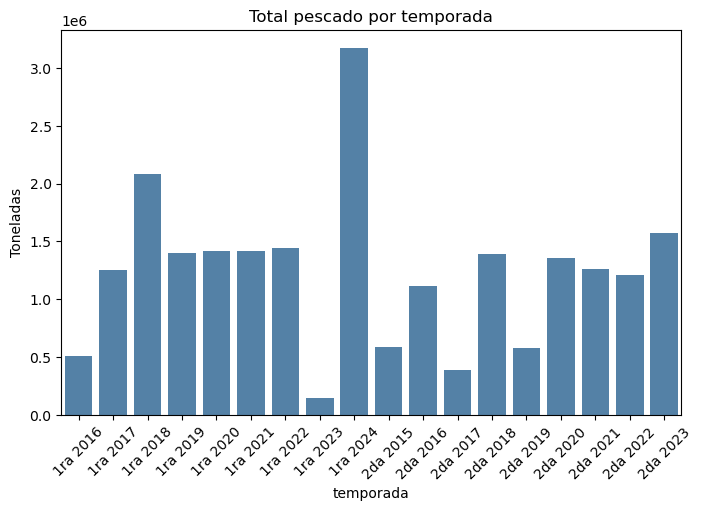

In [23]:

import seaborn as sns

totales = df_stats.groupby("temporada", as_index=False)["total_pescado_tm"].first()

plt.figure(figsize=(8,5))
sns.barplot(data=totales, x="temporada", y="total_pescado_tm", color="steelblue")
plt.title("Total pescado por temporada")
plt.ylabel("Toneladas")
plt.xticks(rotation=45)
plt.show()

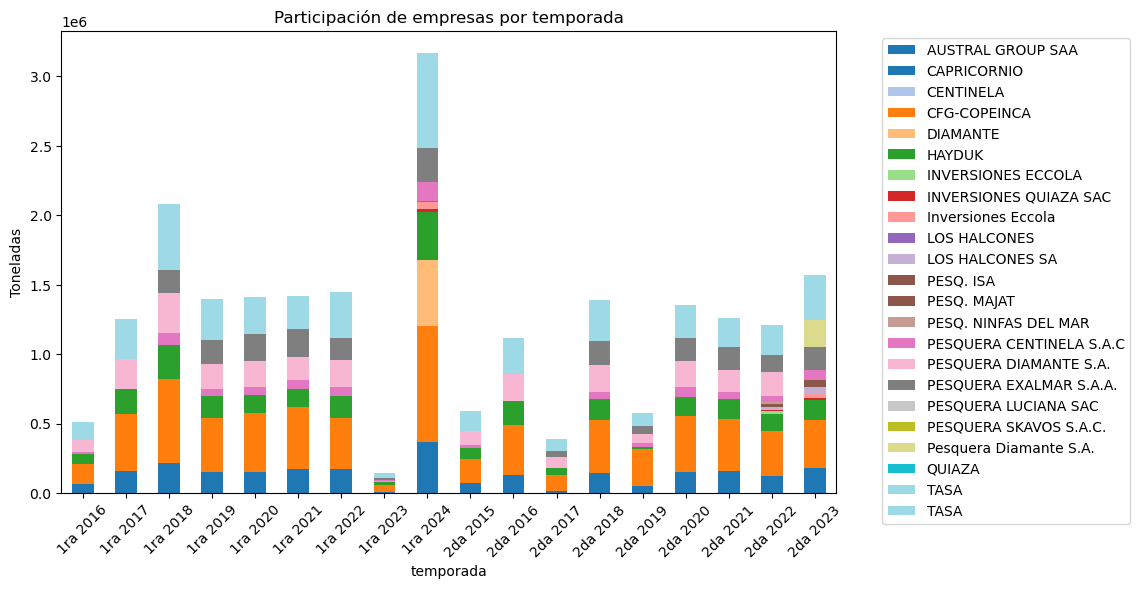

In [24]:
pivot_empresas = df_stats.pivot_table(
    index="temporada",
    columns="empresa",
    values="volumen_empresa_tm",
    aggfunc="sum",
    fill_value=0
)

pivot_empresas.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="tab20"
)
plt.ylabel("Toneladas")
plt.title("Participación de empresas por temporada")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


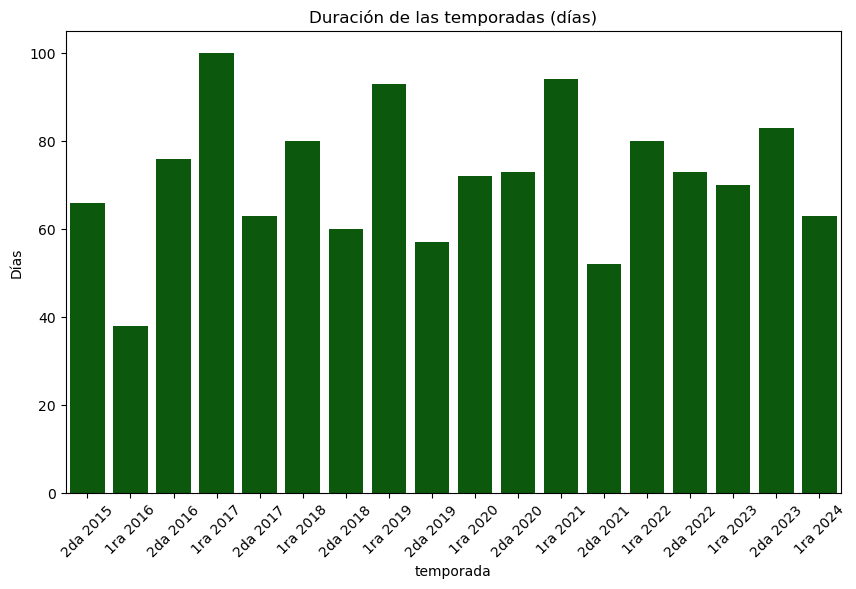

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_stats.drop_duplicates("temporada"), x="temporada", y="duracion_dias", color="darkgreen")
plt.title("Duración de las temporadas (días)")
plt.ylabel("Días")
plt.xticks(rotation=45)
plt.show()


In [ ]:
visualizer = CalasDataset("/home/jupyter-daniela/suyana/peru_production/inputs/")
anios = [year for year in range(2015, 2025)]

for year in anios:
    print(f"Procesando año: {year}")
    try:
        df = visualizer.cargar_datos(year)
        df_estadisticas = visualizer.estadisticas_datos()
        
        visualizer.visualizar_datos(year)
    except FileNotFoundError as e:
        print(e)

Procesando año: 2015
Archivos encontrados para el año 2015: ['Segunda temporada de anchoveta – Calas y biometría.csv']
Procesando año: 2016
Archivos encontrados para el año 2016: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Procesando año: 2017
Archivos encontrados para el año 2017: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Procesando año: 2018
Archivos encontrados para el año 2018: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Procesando año: 2019
Archivos encontrados para el año 2019: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Procesando año: 2020
Archivos encontrados para el año 2020: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.cs

## grilla para temperatura

In [ ]:

lat_bins = sorted(GRILLAS['temperatura']['lat_bins'])
lon_bins = sorted(GRILLAS['temperatura']['lon_bins'])

dfs = []
for year in anios:
    try:
        df = visualizer.cargar_datos(year)
        dfs.append(df)
    except FileNotFoundError:
        continue

df_todos = pd.concat(dfs, ignore_index=True)
visualizer.df = df_todos

grilla = visualizer.grillado_semanal(lat_bins, lon_bins)

grilla.to_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_grillado_semanal.csv", index=False)

## grilla para SSS


In [ ]:
lat_bins = sorted(GRILLAS['sss']['lat_bins'])
lon_bins = sorted(GRILLAS['sss']['lon_bins'])

dfs = []
for year in anios:
    try:
        df = visualizer.cargar_datos(year)
        dfs.append(df)
    except FileNotFoundError:
        continue

df_todos = pd.concat(dfs, ignore_index=True)
visualizer.df = df_todos

grilla = visualizer.grillado_semanal(lat_bins, lon_bins)

grilla.to_csv("/home/jupyter-daniela/suyana/peru_production/outputs/calas_grillado_semanal_grilla_SSS.csv", index=False)


Archivos encontrados para el año 2015: ['Segunda temporada de anchoveta – Calas y biometría.csv']
Archivos encontrados para el año 2016: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Archivos encontrados para el año 2017: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Archivos encontrados para el año 2018: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Archivos encontrados para el año 2019: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Archivos encontrados para el año 2020: ['Segunda temporada de anchoveta – Calas y biometría.csv', 'Primera temporada de anchoveta – Calas y biometría.csv']
Archivos encontrados para el año 2021: ['Primera temporada de pesca de anchoveta – Calas y biometría.csv', 'Segunda tempor

In [ ]:
for year in anios:
    print(f"Procesando año: {year}")
    for temporada in ['1ra', '2da']:
        temporada_objetivo = temporada + f' {year}'
        grilla_temp = grilla[grilla['temporada'] == temporada_objetivo]
        if grilla_temp.empty:
            print(f"Sin datos para la temporada {temporada_objetivo}")
            continue
        try:
            visualizer.visualizar_grilla(grilla, temporada_objetivo=temporada_objetivo)
        except FileNotFoundError as e:
            print(e)
